In [1]:
!pip install tensorflow_hub


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import logging
import os
import warnings
from time import time

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
import keras
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

# from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [3]:
repo = '/home/jovyan/'
labels_train = pd.read_csv(repo + 'hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/labels_train.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(labels_train['filename'], labels_train.drop('filename', axis=1), test_size=0.2, random_state=44)

In [5]:
print("Number of runaway for training: ", len(X_train))
print("Number of runaway for validation: ", len(X_test))

Number of runaway for training:  664
Number of runaway for validation:  166


In [6]:
path = '/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/train/'

In [7]:
X_train = [os.path.join(path, str(f)) for f in X_train]
X_test = [os.path.join(path, str(f)) for f in X_test]
X_train[:3]

['/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/train/BDCAEROD0000000017183103_runway_3_gridsize_512_idx_3_idy_0.jpg',
 '/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/train/BDCAEROD0000000017183088_runway_1_gridsize_512_idx_11_idy_0.jpg',
 '/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/train/BDCAEROD0000000017183099_runway_3_gridsize_512_idx_7_idy_0.jpg']

In [8]:
y_train = y_train.values
y_test = y_test.values

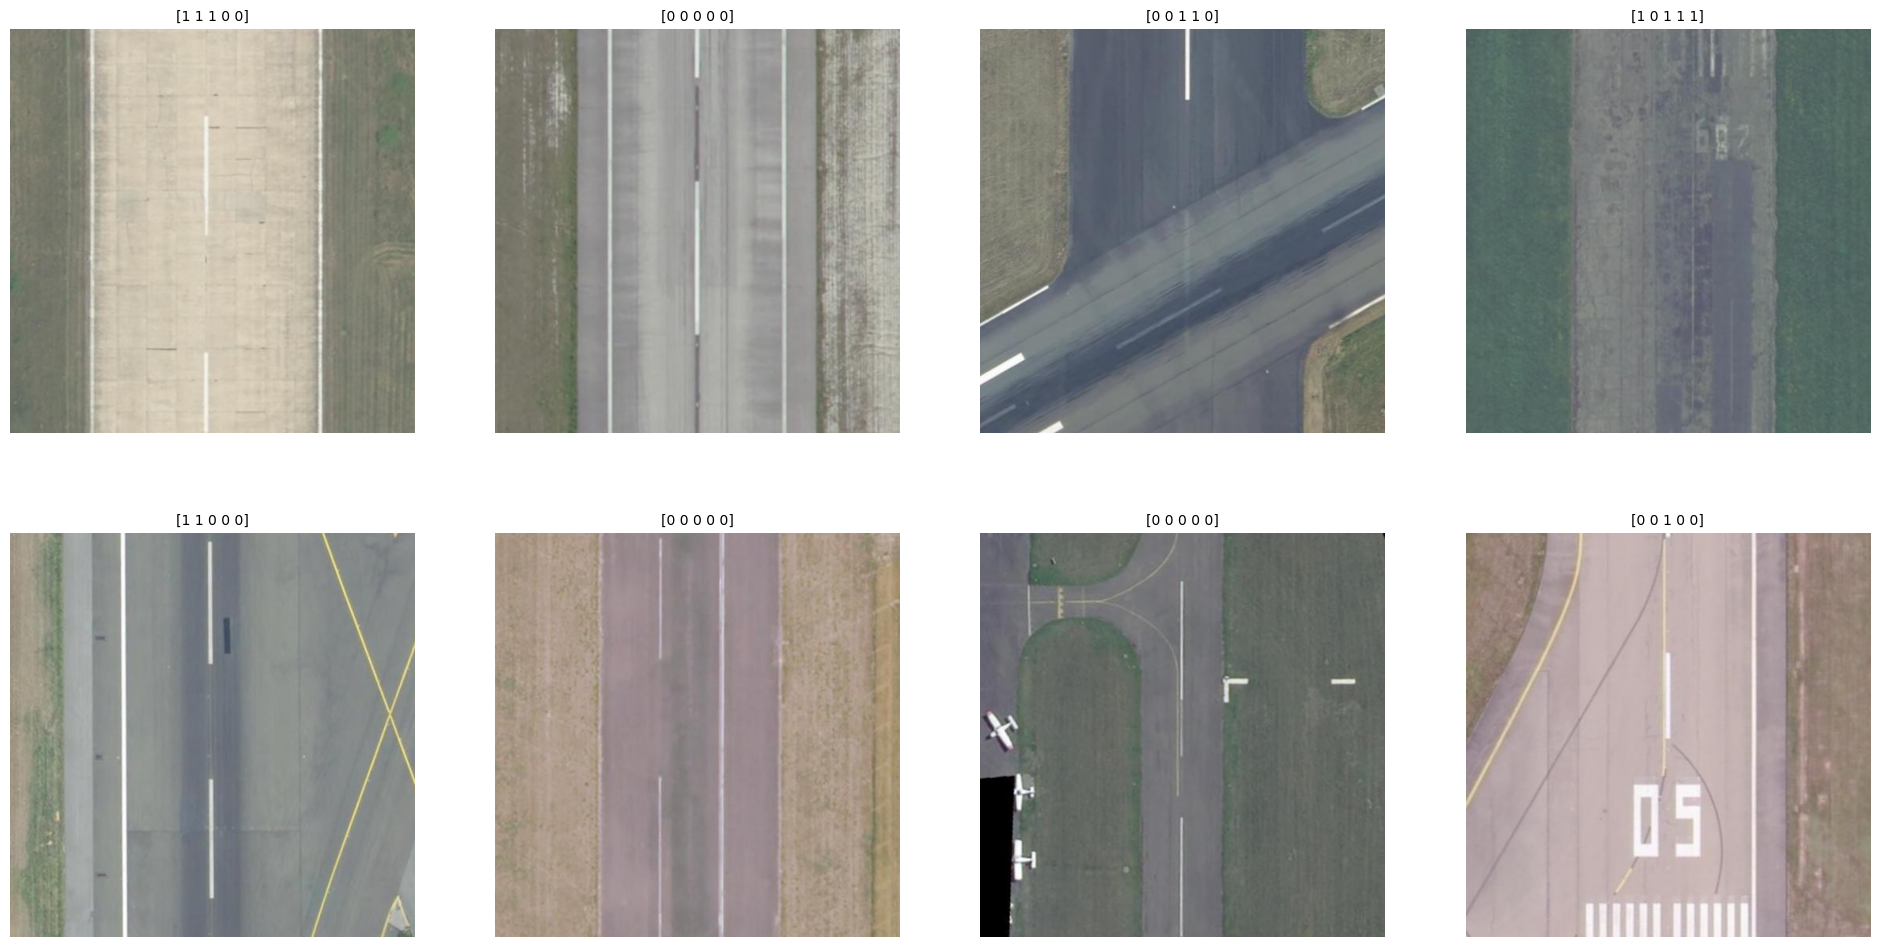

In [9]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(24,6*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

In [10]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [11]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
      # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
      # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
          image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)

    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [1]:
def parse_function(filename, label, seed=(1, 2)):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    # Random brightness.
    image_brightened = tf.image.stateless_random_brightness(
        image_normalized, max_delta=0.2, seed=seed)
    # image_augmented = tf.image.stateless_random_contrast(
    #     image_augmented, lower=0.4, upper=0.6, seed=seed)
    # image_augmented = tf.image.stateless_random_jpeg_quality(
    #     image_augmented, min_jpeg_quality=75, max_jpeg_quality=100, seed=seed)
    image_flip_left_right = tf.image.stateless_random_flip_left_right(
        image_brightened, seed=seed)
    image_augmented = tf.image.stateless_random_flip_up_down(
        image_flip_left_right, seed)
    
    return image_augmented, label
    # return image_normalized, label

In [13]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [14]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [15]:
train_ds = create_dataset(X_train, y_train)
#test_ds = create_dataset(X_test, y_test)

2022-11-08 23:28:23.190901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 23:28:23.200979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 23:28:23.202035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 23:28:23.204038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
test_ds = create_dataset(X_test, y_test)

In [17]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.int64)>

In [18]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 5)


In [19]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
# "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
# "https://tfhub.dev/google/bit/m-r101x3/1" 
# "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2" 
# "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5" 
# "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [20]:
feature_extractor_layer.trainable = False

In [21]:
N_LABELS = y_train.shape[1]

In [22]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 5)                 5125      
                                                                 
Total params: 5,543,301
Trainable params: 1,316,869
Non-trainable params: 4,226,432
_________________________________________________________________


In [23]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost


In [24]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [25]:
LR = 5e-5 # Keep it small when transfer learning
EPOCHS = 500

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [27]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_test, y_test),
                    callbacks=[
                            tf.keras.callbacks.ModelCheckpoint(
                                os.path.join(repo + 'hfactory_magic_folders/colas_data_challenge/group_shared_workspace/Models/saved_models/21th_model_augustin_LR_0_00005_MobileNetV3_500E_augmented/', 
                                             'epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5'),
                                monitor='val_loss', save_best_only=True
        )
    ])
print(f'Training took {round(time()-start, 2)} sec')

Epoch 1/500


2022-11-08 23:28:31.974871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2022-11-08 23:28:32.496895: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:28:32.499961: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:28:32.500009: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-08 23:28:32.502492: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:28:32.502603: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


3/3 [==============================] - 8s 1s/step - loss: 0.7393 - macro_f1: 0.2642 - val_loss: 0.7607 - val_macro_f1: 0.2585
Epoch 2/500
3/3 [==============================] - 1s 302ms/step - loss: 0.7187 - macro_f1: 0.3039 - val_loss: 0.7490 - val_macro_f1: 0.2619
Epoch 3/500
3/3 [==============================] - 1s 299ms/step - loss: 0.7044 - macro_f1: 0.3174 - val_loss: 0.7397 - val_macro_f1: 0.2732
Epoch 4/500
3/3 [==============================] - 1s 299ms/step - loss: 0.6916 - macro_f1: 0.3461 - val_loss: 0.7313 - val_macro_f1: 0.2994
Epoch 5/500
3/3 [==============================] - 1s 296ms/step - loss: 0.6809 - macro_f1: 0.3576 - val_loss: 0.7226 - val_macro_f1: 0.3162
Epoch 6/500
3/3 [==============================] - 1s 304ms/step - loss: 0.6702 - macro_f1: 0.3784 - val_loss: 0.7132 - val_macro_f1: 0.3440
Epoch 7/500
3/3 [==============================] - 1s 297ms/step - loss: 0.6590 - macro_f1: 0.3892 - val_loss: 0.7033 - val_macro_f1: 0.3480
Epoch 8/500
3/3 [===========

In [28]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

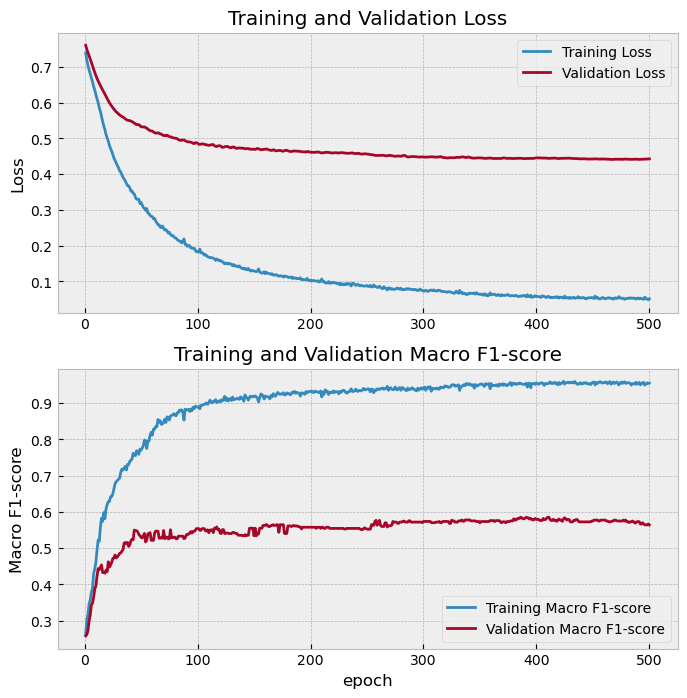

In [29]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)


In [35]:
def show_prediction(ID, model, test_or_train='train'):
    
    if test_or_train == 'train':
        path = '/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/train/'
    else:
        path = '/home/jovyan/hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/test/'
    img_path = os.path.join(path, str(ID))
    trues_values = labels_train[labels_train['filename'] == str(ID.replace(path, ''))].drop('filename', axis=1).values#[0]
    
    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    # prediction.index = mlb.classes_
    # prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title(f'''True values for runaway {ID.replace(path, '')} : 
    {trues_values}
    
    Predictions : 
    {prediction.values}''')
    plt.show()


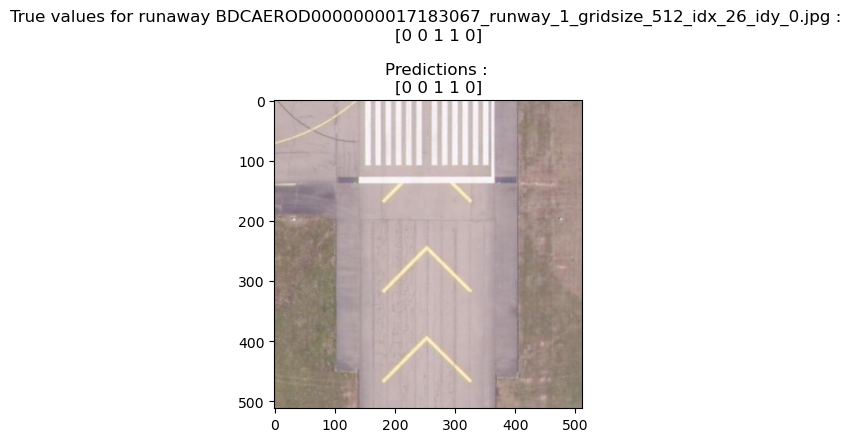

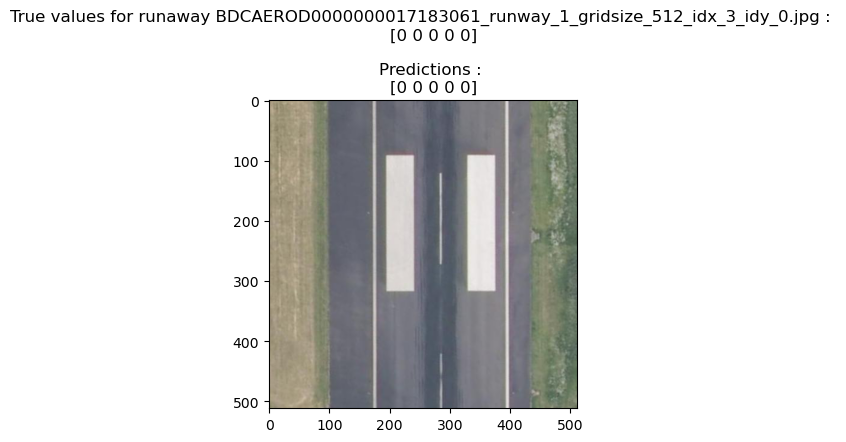

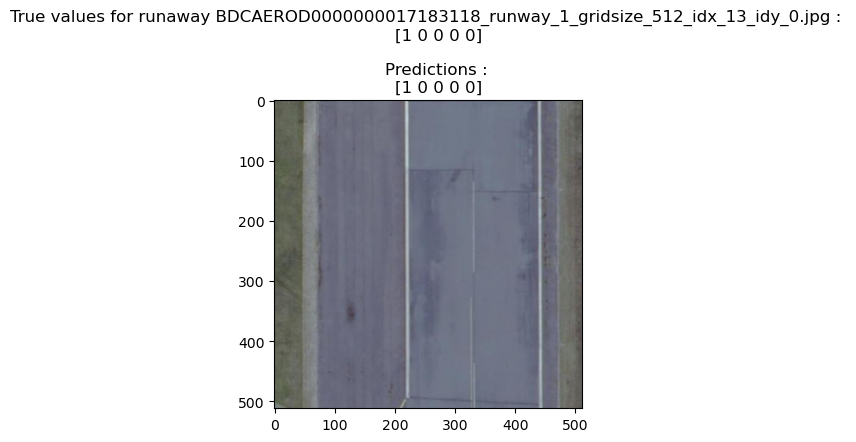

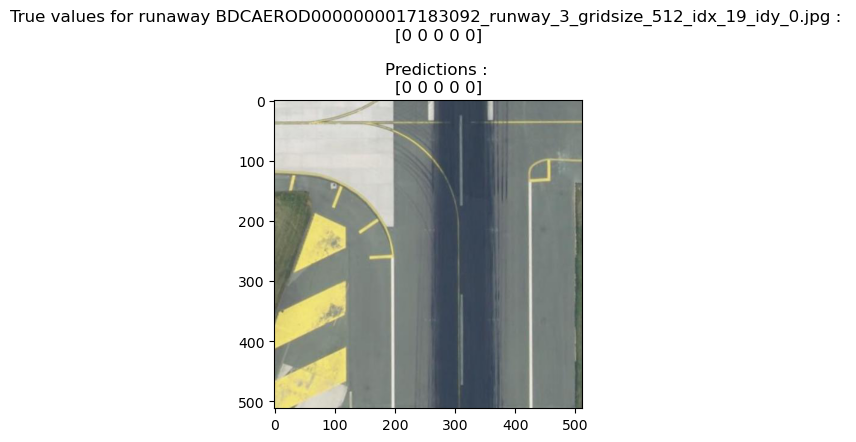

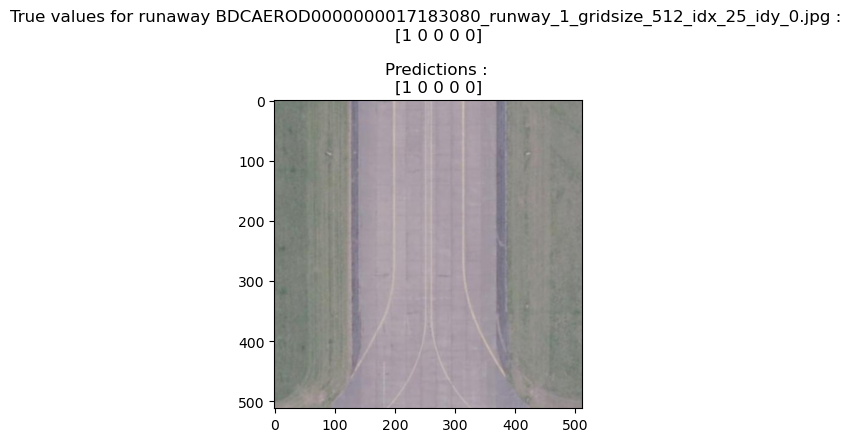

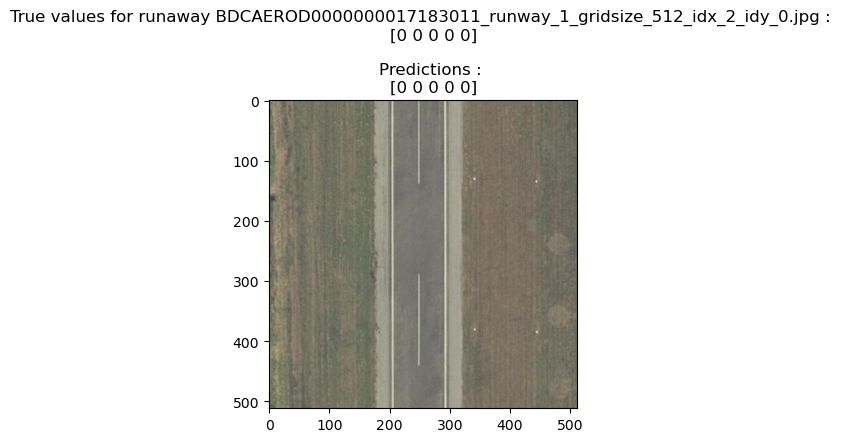

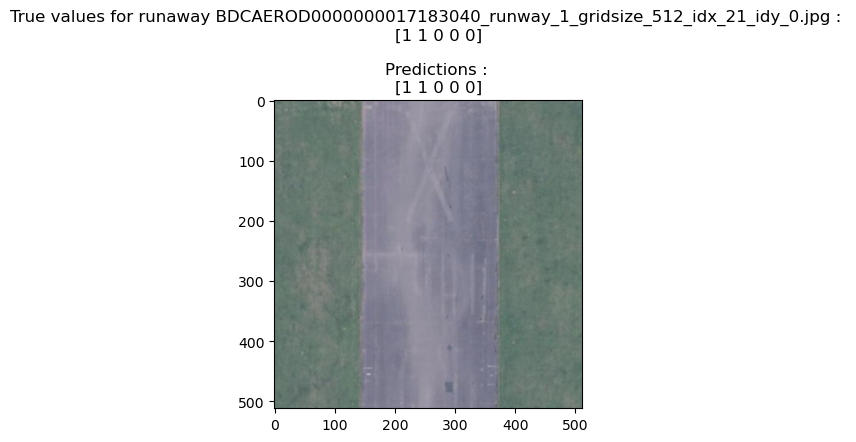

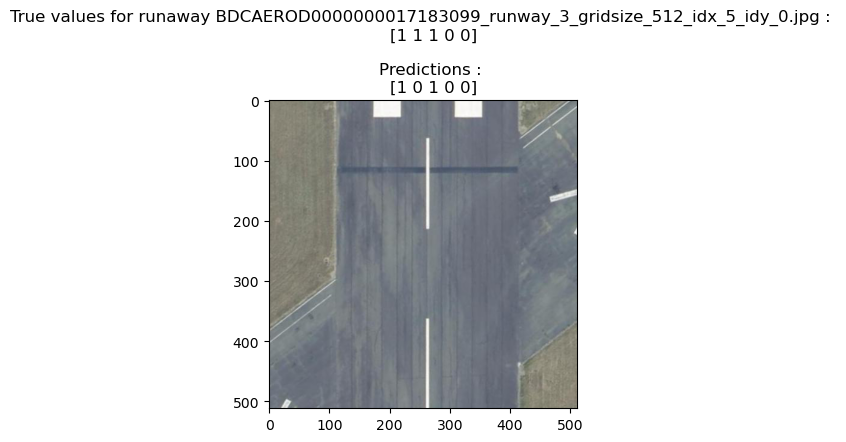

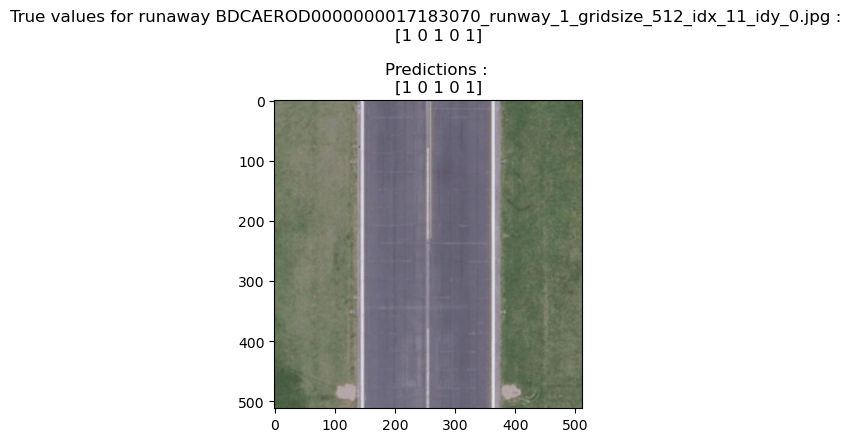

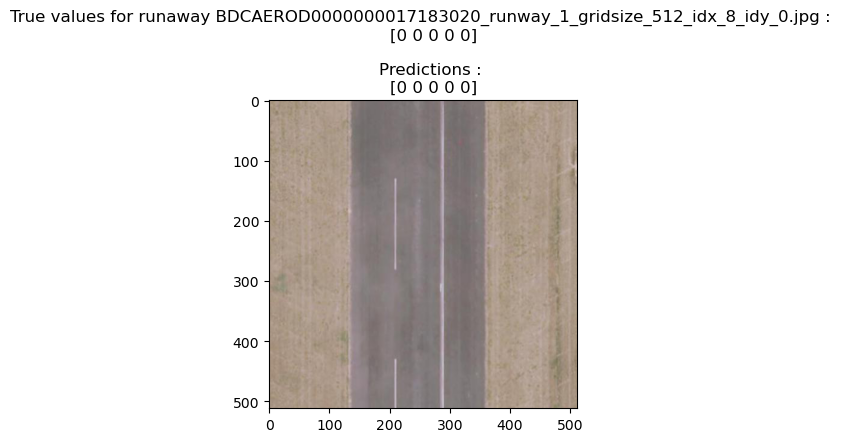

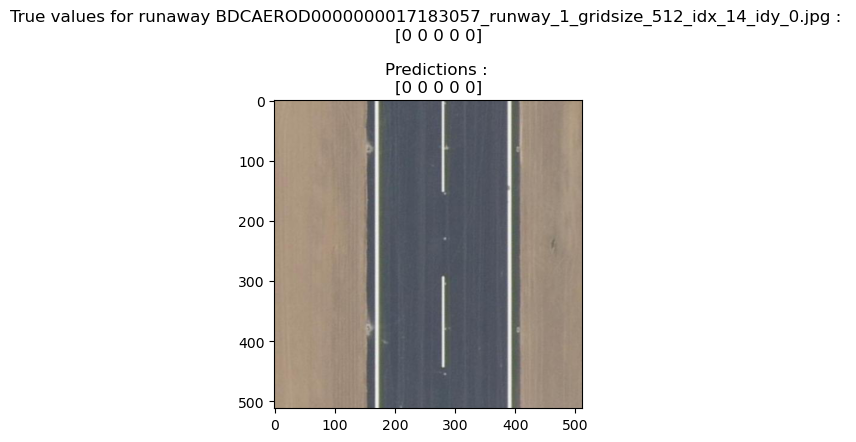

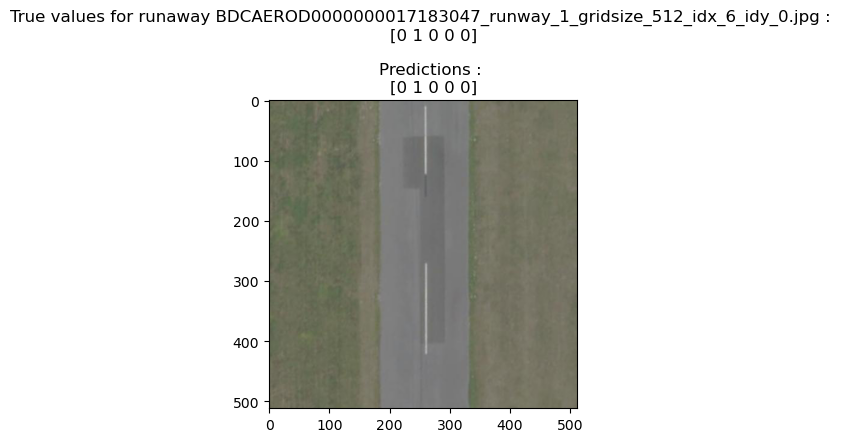

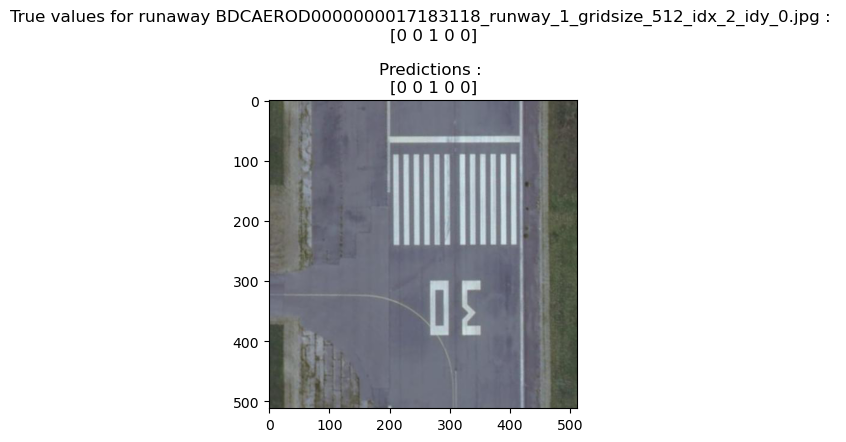

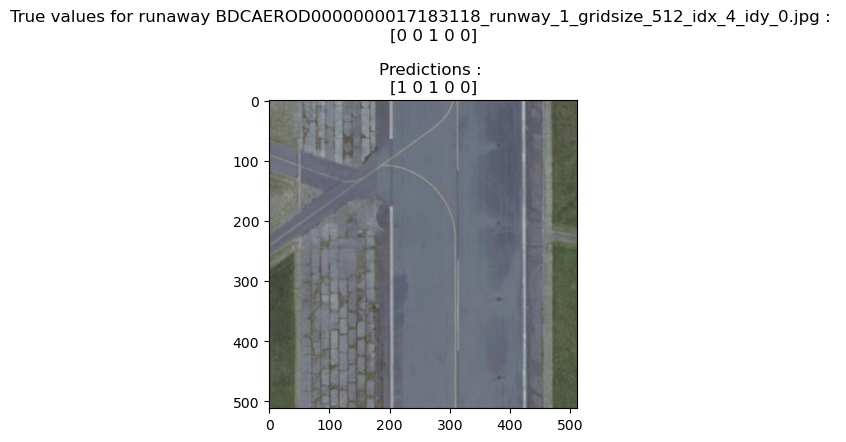

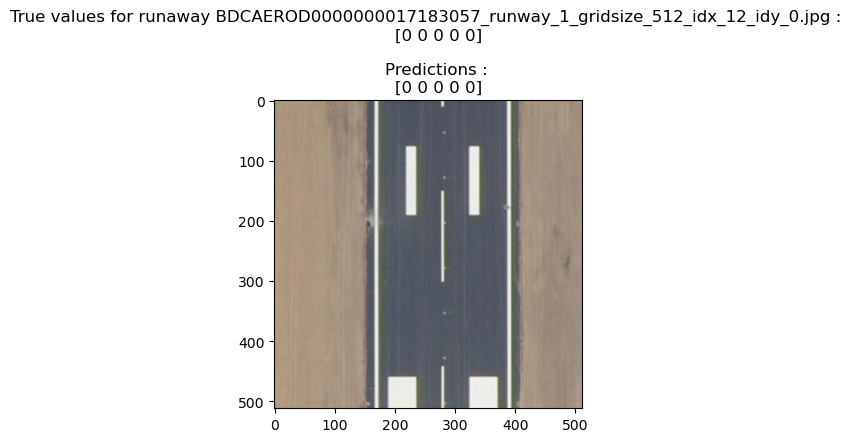

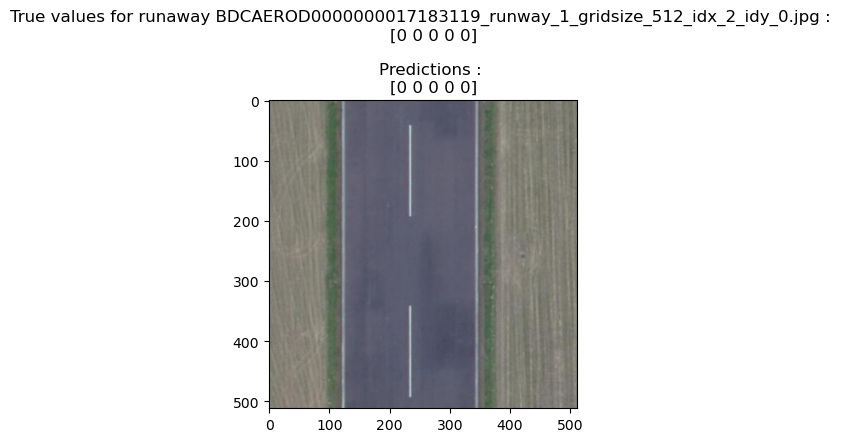

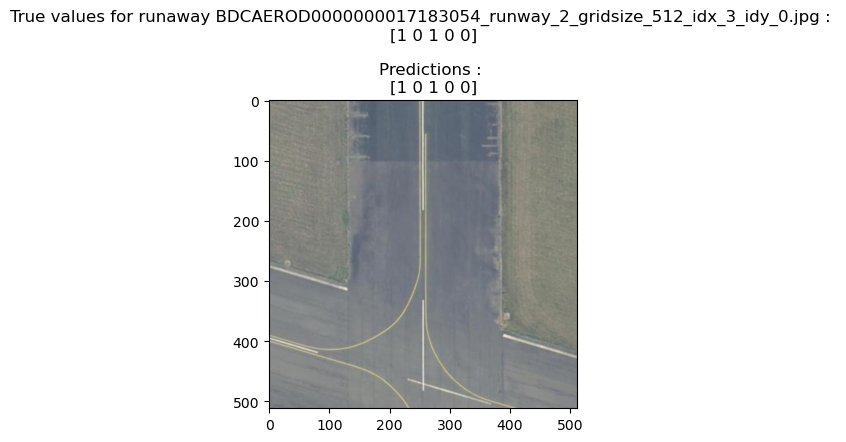

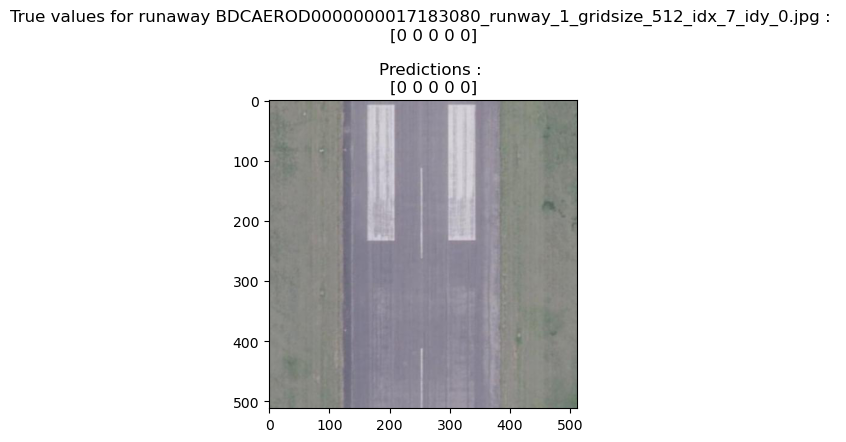

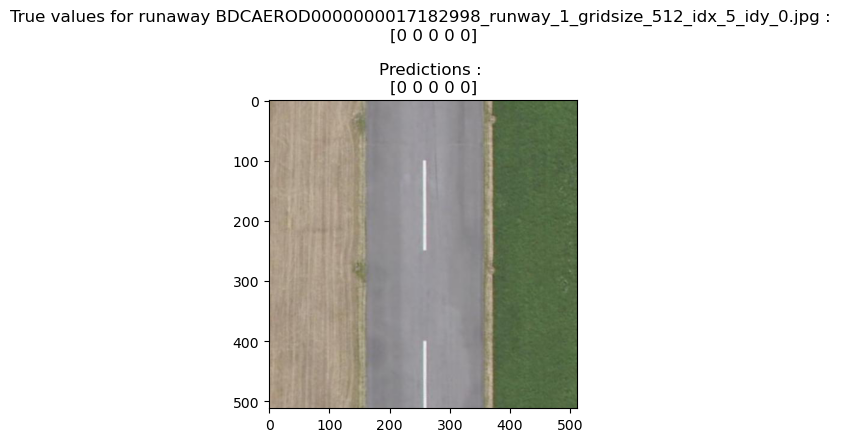

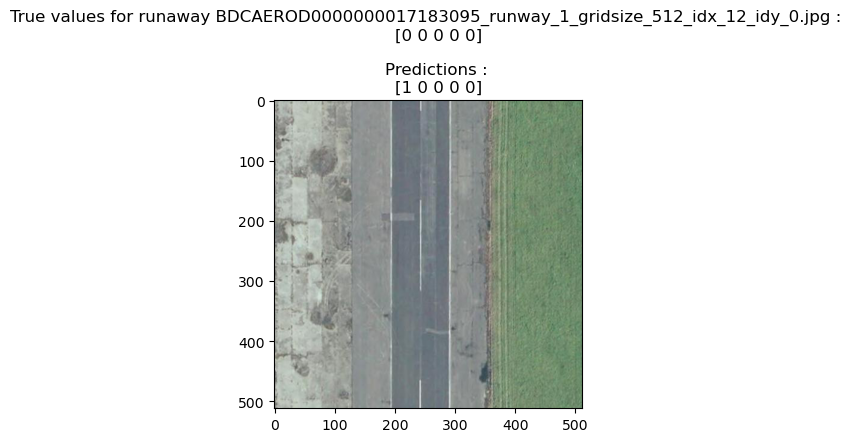

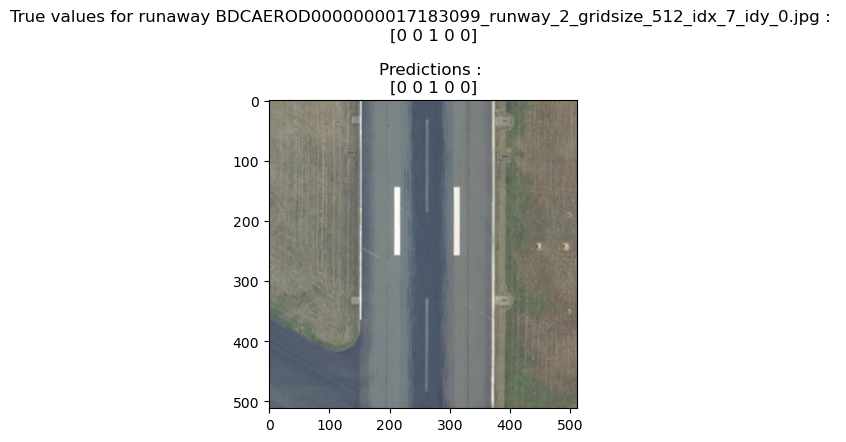

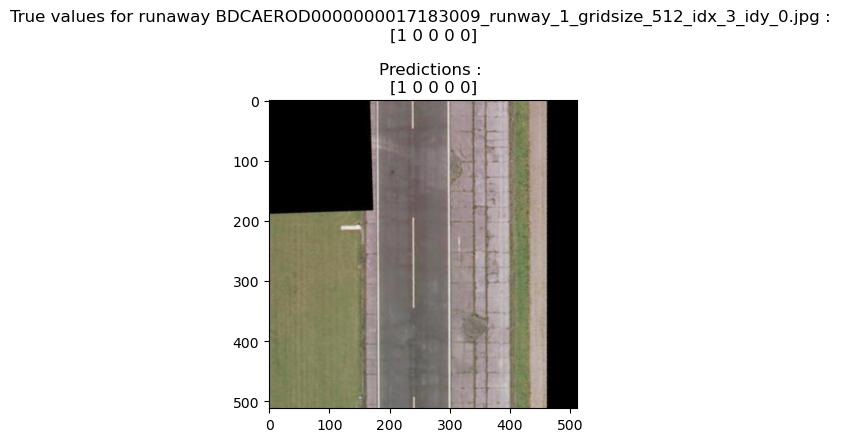

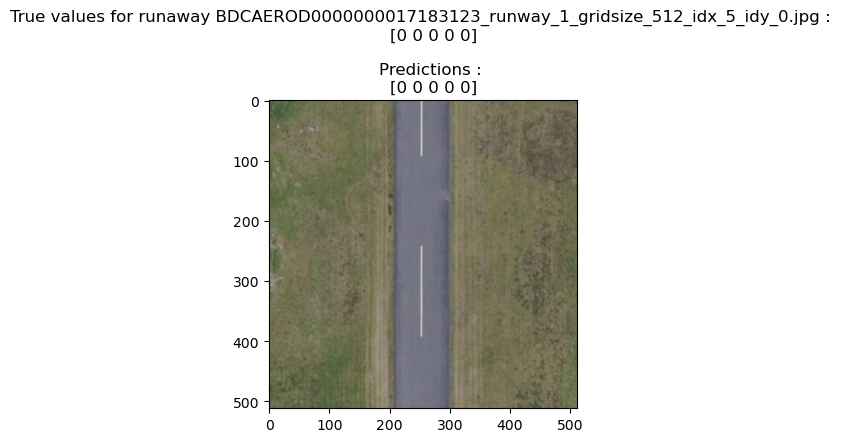

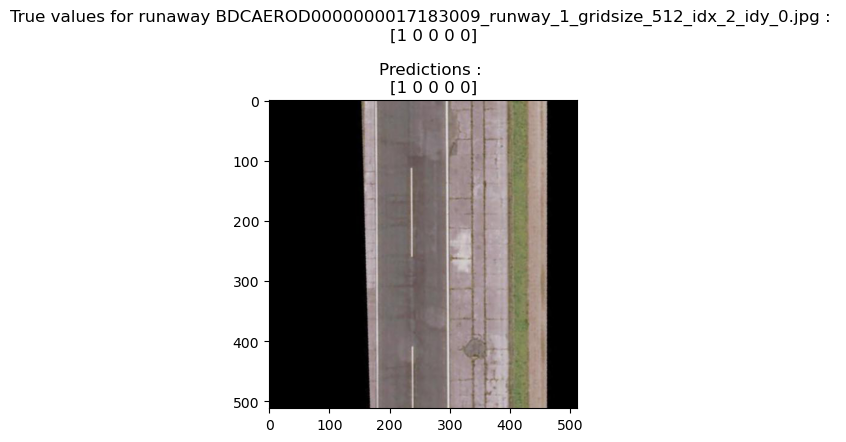

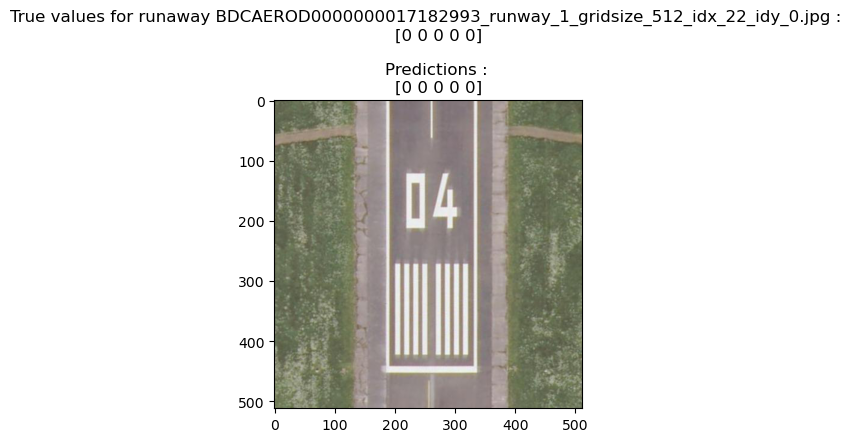

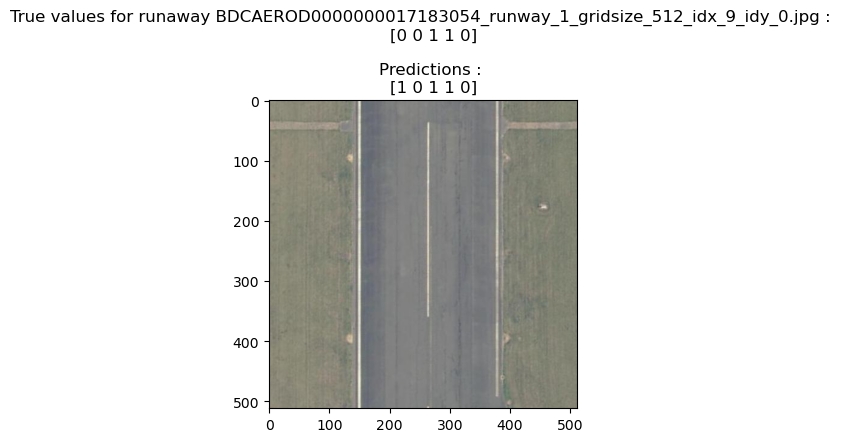

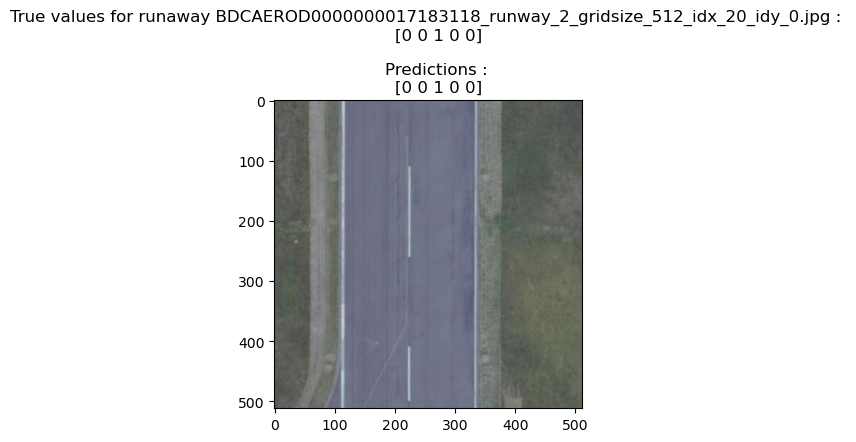

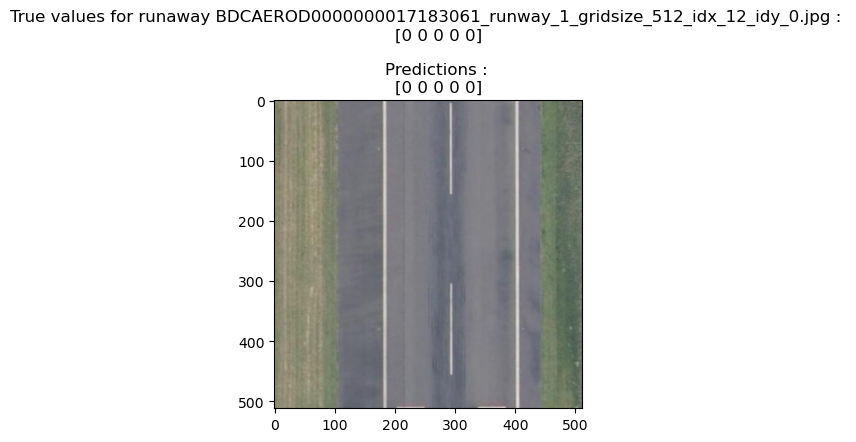

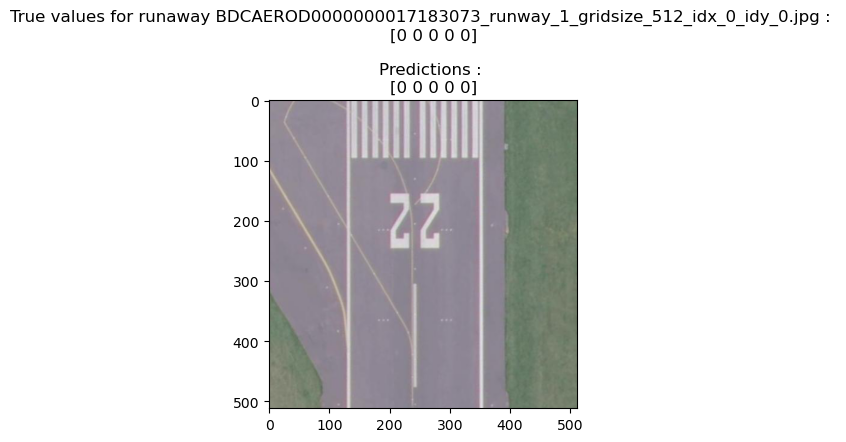

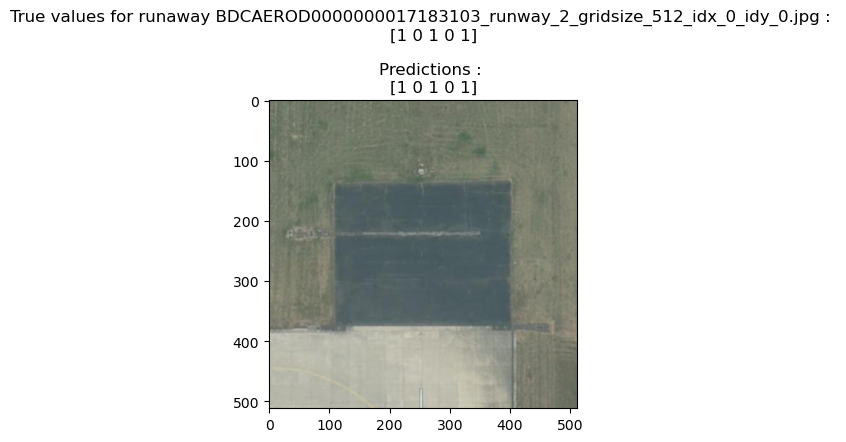

In [31]:
for id_ in X_train[20:50]:
    show_prediction(id_, 
                    model)

In [32]:
template_test = pd.read_csv(repo + 'hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/template_test.csv')

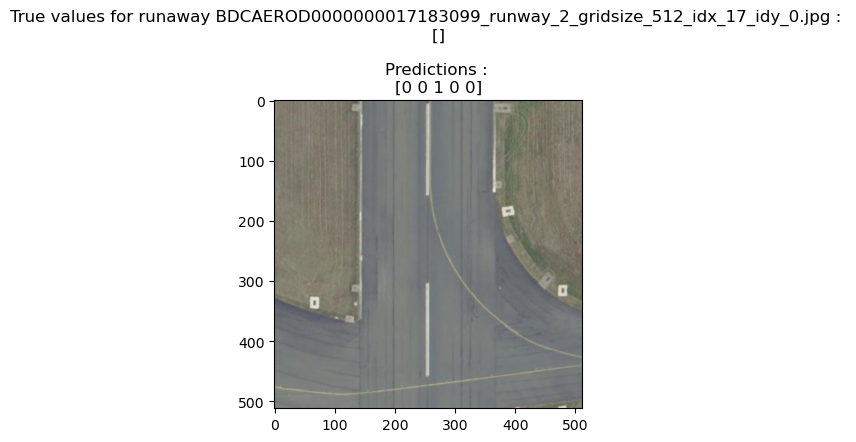

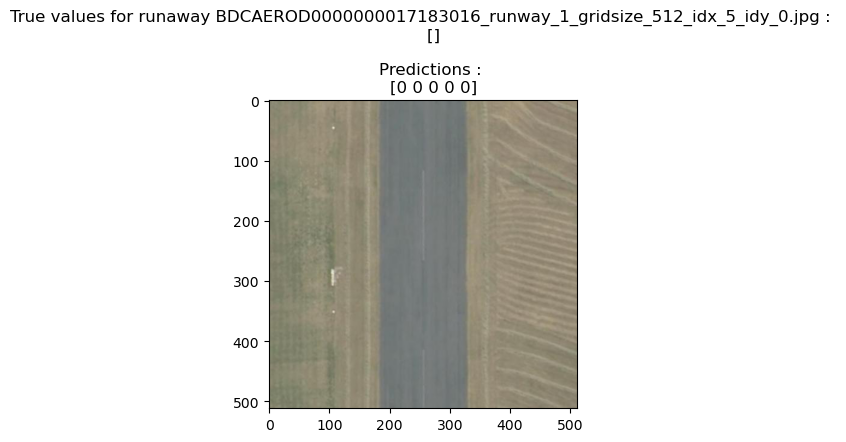

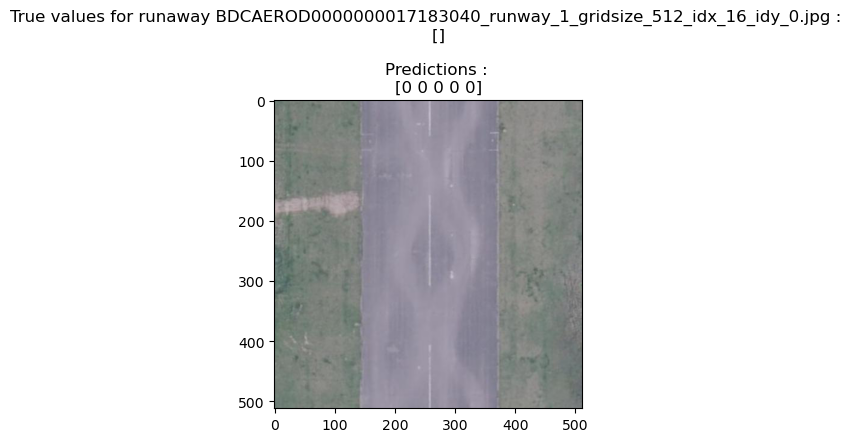

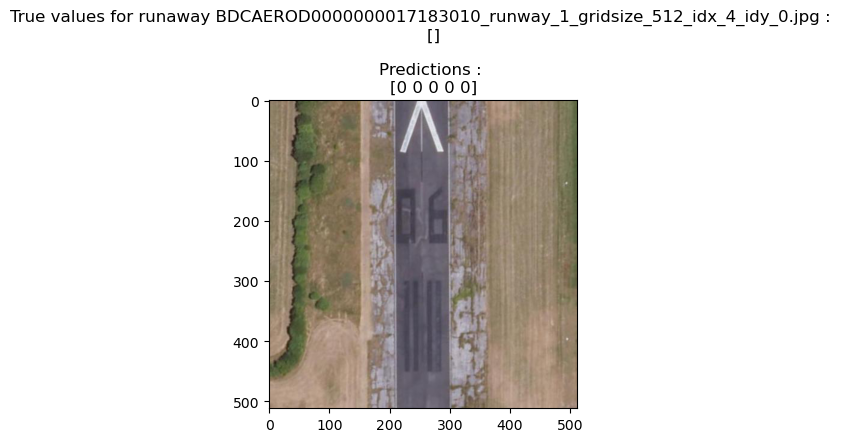

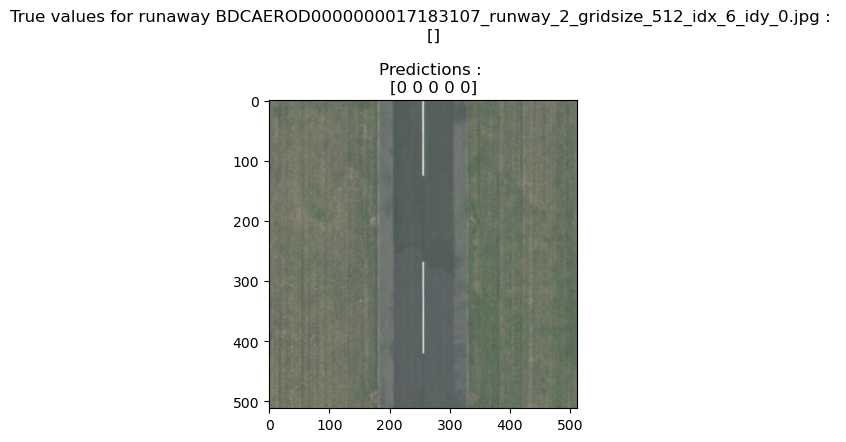

In [38]:
for id_ in template_test.filename[:5]:
    show_prediction(id_,
                    model,
                   'test')

In [39]:
def make_prediction(IDs, path, model):
    for idx, ID in enumerate(IDs):
        img_path = os.path.join(path, str(ID))
        trues_values = labels_train[labels_train['filename'] == str(ID)].drop('filename', axis=1).values

        # Read and prepare image
        img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
        img = image.img_to_array(img)
        img = img/255
        img = np.expand_dims(img, axis=0)

        # Generate prediction
        prediction = (model.predict(img) > 0.5).astype('int')[0]
        if idx == 0:
            predictions = prediction
        else:
            predictions = np.vstack([predictions, prediction])

    return predictions

In [40]:
predictions = make_prediction(template_test.filename, 
                              repo+'hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/test',
                              model)

In [41]:
predictions.shape

(200, 5)

In [42]:
ninetinth_model_to_submit = pd.DataFrame(predictions, columns=template_test.columns[1:])
ninetinth_model_to_submit['filename'] = template_test.filename
ninetinth_model_to_submit = ninetinth_model_to_submit[['filename', 'FISSURE', 'REPARATION', 'FISSURE LONGITUDINALE', 'FAÏENCAGE',
       'MISE EN DALLE']]

In [44]:
ninetinth_model_to_submit.to_csv(repo + 'hfactory_magic_folders/colas_data_challenge/group_shared_workspace/Models/submissions/' + '19th_model_to_submit.csv')




In [43]:
ninetinth_model_to_submit

filename  FISSURE  REPARATION  \
0    BDCAEROD0000000017183099_runway_2_gridsize_512...        0           0   
1    BDCAEROD0000000017183016_runway_1_gridsize_512...        0           0   
2    BDCAEROD0000000017183040_runway_1_gridsize_512...        0           0   
3    BDCAEROD0000000017183010_runway_1_gridsize_512...        0           0   
4    BDCAEROD0000000017183107_runway_2_gridsize_512...        0           0   
..                                                 ...      ...         ...   
195  BDCAEROD0000000017183053_runway_1_gridsize_512...        1           1   
196  BDCAEROD0000000017183067_runway_1_gridsize_512...        0           0   
197  BDCAEROD0000000017183053_runway_1_gridsize_512...        1           0   
198  BDCAEROD0000000017183092_runway_2_gridsize_512...        0           0   
199  BDCAEROD0000000017183103_runway_1_gridsize_512...        0           0   

     FISSURE LONGITUDINALE  FAÏENCAGE  MISE EN DALLE  
0                        1          0              0  
1                        0          0              0  
2                        0          0              0  
3                        0          0              0  
4                        0          0              0  
..                     ...        ...            ...  
195                      1          1              1  
196                      1          0              0  
197                      1          0              1  
198                      0          0              0  
199                      0          0              0  

[200 rows x 6 columns]